## Прогнозирование группы пользователей для осуществления таргетированной рекламы банковского продукта

### Описание проекта
Задача банка предложить потребительский кредит и при этом максимизировать [показатель конверсии](https://www.unisender.com/ru/support/about/glossary/chto-takoe-cr-conversion-rate/), который равен отношению количества пользователей, принявших кредит, к общему количеству пользователей, которым поступили предложения *(precision)*. Решение этой задачи актуально для банка, потому что это позволит сократить расходы на персональный маркетинг, но при этом достичь максимальной выгоды. Данный проект оптимизирует выбор кандидатов для персонального предложения о предоставлении кредита. В процесс отбора кандидатов можно внерить алгоритм отсева потенциальных кандидатов, готовых взять кредит. 
### Постановка бизнес и математической задачи
Предположительно, нам известно сколько было затрачено времени и средств на проведение прошлогодней кампании. Для измерения бизнес цели мы планируем использовать сравнение затраченных и полученных средств текущей и прошлогодней кампании. Критерий успеха — доход, превышающий доход прошлогодней кампании (или превышение предсказанных показателей дохода, тк может быть тренд увеличения прибыли).

С математической точки зрения мы хотим, чтобы как можно больше людей из тех, кого мы выберем приняли наше предложение. Нам требуется построить бинарный классификатор, с вероятностными прогнозами. Для повышения показателя конверсии нам необходимо оптимизировать precision, но так же необходимо охватить больше потенциально согласных пользователей, поэтому мы будем оптимизировать __F1 score__ и следить за __precision__.

### Особенности предметной области
Для банковской сферы показатели качества часто бывают гораздо менее важными, чем простота самой модели и простота ее интерпретации. Это следует учесть при выборе финальной модели.

### Содержание 
+ [Описание колонок](#description_cell)
+ [EDA](#eda_cell)
+ [Train/Test split](#split_metrics_cell)
+ [Baseline](#baseline_cell)
+ [Feature engineering](#feature_cell)
+ [Model building](#model_cell)
+ [Conclusion](#conclusion_cell)

In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from graphviz import Source
from sklearn import tree

RANDOM_STATE = 12

In [2]:
file_name = "BPL.csv"
df = pd.read_csv(file_name)
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


<a id='description_cell'></a>

## Описание колонок
* **ID** : ID пользователя

* **Age** : Число полных лет пользователя

* **Experience** : Стаж работы

* **Income** : Средний месячный доход в тысячах долларов

* **ZIP Code** : Почтовый индекс

* **Family** : Размер семьи

* **CCAvg** : Средняя трата по кредитной карте за месяц

* **Education** : Степень образования.
   0. Среднее  
   1. Высшее  
   2. Доктор наук  
   

* **Mortgage** : Стоимость ипотеки при наличии. (в тысячах долларов)

* **Personal Loan** : Принял ли клиент предожение в прошлогодней кампании

* **Securities Account** : Есть ли у клиента счет в банке с ценными бумагами(брокерский счет)

* **CD Account** : Есть ли у клиента банковский вклад

* **Online** : Пользуется ли клиент услугами интернет - банкинга?

* **Credit card** : Использует ли клиент кредитную карту, выпущенную банком

<a id='eda_cell'></a>

# EDA

In [3]:
# there are no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Видим, что все колонки имеют тип данных int64. Так как в датасете присутствует 5000 семплов, пропущенных значений не наблюдается.
Некоторые колонки можно интерпретировать одновременно и как категориальные, и как номенативные.

In [4]:
# numeric and categorical features
num_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
intersection_cols = ['Education', 'Family']
cat_cols = list((set(df.columns) - set(num_cols)).union(set(intersection_cols)))

print('Numeric Columns:', num_cols)
print('Categorical Columns:', cat_cols)
print('Intersection Columns:', intersection_cols)

Numeric Columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
Categorical Columns: ['ID', 'Securities Account', 'Family', 'CD Account', 'CreditCard', 'Personal Loan', 'Online', 'Education']
Intersection Columns: ['Education', 'Family']


In [5]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [6]:
df.describe().loc['min']

ID                       1.0
Age                     23.0
Experience              -3.0
Income                   8.0
ZIP Code              9307.0
Family                   1.0
CCAvg                    0.0
Education                1.0
Mortgage                 0.0
Personal Loan            0.0
Securities Account       0.0
CD Account               0.0
Online                   0.0
CreditCard               0.0
Name: min, dtype: float64

In [7]:
print(df[df['Experience'] < 0].shape)
df[df['Experience'] < 0].sample(10)

(52, 14)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
524,525,24,-1,75,93014,4,0.2,1,0,0,0,0,1,0
3425,3426,23,-1,12,91605,4,1.0,1,90,0,0,0,1,0
2618,2619,23,-3,55,92704,3,2.4,2,145,0,0,0,1,0
89,90,25,-1,113,94303,4,2.3,3,0,0,0,0,0,1
3279,3280,26,-1,44,94901,1,2.0,2,0,0,0,0,0,0
3887,3888,24,-2,118,92634,2,7.2,1,0,0,1,0,1,0
536,537,25,-1,43,92173,3,2.4,2,176,0,0,0,1,0
1173,1174,24,-1,35,94305,2,1.7,2,0,0,0,0,0,0
4285,4286,23,-3,149,93555,2,7.2,1,0,0,0,0,1,0
4015,4016,25,-1,139,93106,2,2.0,1,0,0,0,0,0,1


В колонке Experience мы можем наблюдать отрицательные значения. Это могут быть различные категории/причины отсутствия опыта работы у людей. Данный момент следует уточнить у заказчика, либо внедрить какие-то изменения в колонку Experience.

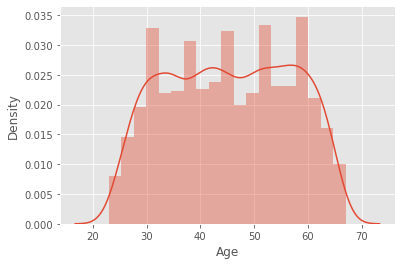

In [8]:
sns.distplot(df['Age'])
plt.show()

In [9]:
df['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

Мы имеем дело с бинарной классификацией по сильно несбалансированной выборке(9:1)  
Рассмотрим корреляцию признаков

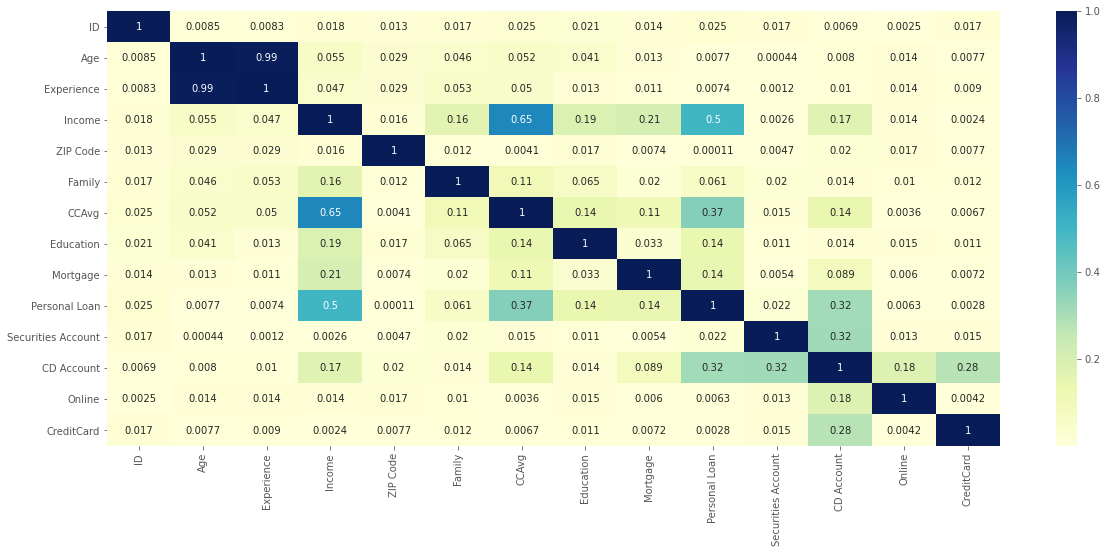

In [10]:
plt.figure(figsize=(20,8))
sns.heatmap(abs(df.corr()), annot=True, fmt='.2g',cmap='YlGnBu')
plt.show()

Видно, что признаки **Experience** и **Age** коррелируют, следовательно, мы можем оставить в данных какой-нибудь один из них

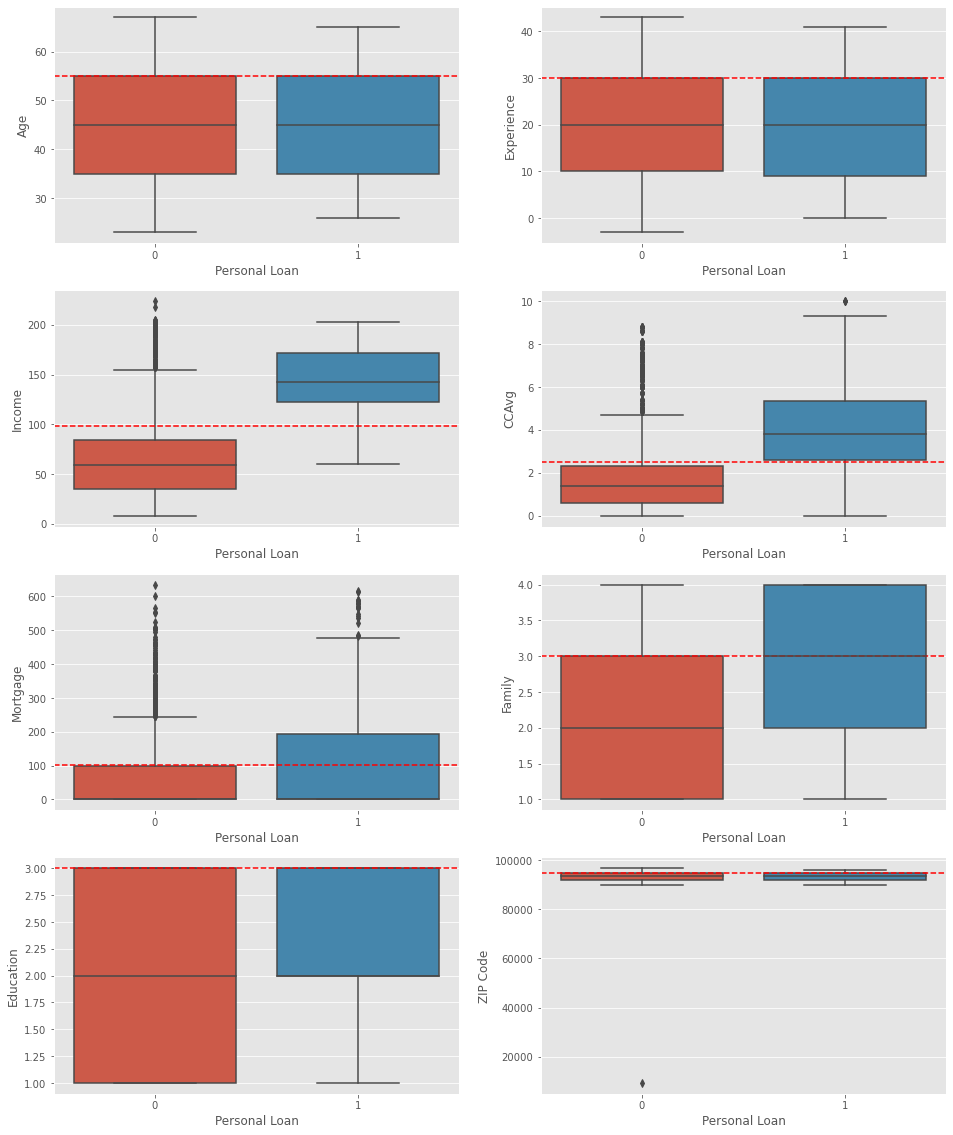

In [11]:
# feature importance
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

for current_column, axis in zip(num_cols, ax.flatten()):
    sns.boxplot(x='Personal Loan', y=current_column, data=df, ax=axis)
    axis.axhline(df.describe().loc['75%', current_column], ls='--', c='red')

Из графиков видно, что:
* **Age** и **Experience** помимо того, что сильно коррелируют друг с другом, плохо предсказывают целевую переменную
* **Mortgage** имеет много нулевых значений, следовательно имеет смысл сделать отдельно категориальную колонку, отвечающую за наличие у человека иппотеки
* Аналогично предыдущему пункту, имеет смысл добавить к **Family** категориальную составляющую, так как наличие членов семьи сильно влияет на целевую переменную
* **Income** и **CCAvg** являются самымим информативными для предсказания таргета

<a id='split_metrics_cell'></a>

# Train/test split + metrics

In [12]:
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            random_state=RANDOM_STATE)
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

<a id='baseline_cell'></a>

# Baseline

Из графиков видно, что параметр дохода явлеется самым информативнм для нас. Сейчас, для выбора пользователей, которые получат персональные предложения, банк искользовал разделение по уровню дохода. Данная модель является имеет слабую конверсию, однако является очень простой в интерпретации для конечного пользователя, что очень важно в банковской сфере. 
Будем отталкиваться от разбиения по параметру Income.

In [13]:
means = df.groupby('Personal Loan')['Income'].mean()
means

Personal Loan
0     66.237389
1    144.745833
Name: Income, dtype: float64

In [14]:
threshold = means.mean()
def baseline_predict(df):
    return df['Income']>threshold
print('Baseline results')
bpred=baseline_predict(X_test_raw)
for score_name, score in metrics.items():
        print(score_name+': '+str(score(y_test,bpred)))

Baseline results
accuracy: 0.84
precision: 0.3495575221238938
recall: 0.8586956521739131
roc_auc: 0.84840068952308
f1: 0.49685534591194963


<a id='feature_cell'></a>

# Feature engineering

In [15]:
train_columns = []

class FeatureSelector(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Drops columns: ID, ZIP Code,'Age, Experience.
    '''

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        
        # опустим коды сотрудников (ID, ZIP Code),
        # а также признаки Age и Experience, в связи с их неинформативностью
        X = X.drop(["ID", "ZIP Code", 'Age', 'Experience'], axis=1) 
        
        global train_columns
        train_columns = X.columns

        return X
    
    
class FeatureGemerator(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Creates several categorical columns
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        
        # is sth features
        X['IsMortgaged'] = X['Mortgage'] > 0
        X['IsFamily'] = X['Family'] > 1
        X['IsEducated'] = X['Education'] > 1

        # Is > than 75 qq
        X['IsMortgaged75'] = (X['Mortgage'] > X.describe().loc['75%', 'Mortgage']) & X['IsMortgaged']
        X['IsIncome75'] = X['Income'] > X.describe().loc['75%', 'Income']
        X['IsCCAvg75'] = X['CCAvg'] > X.describe().loc['75%', 'CCAvg']
        
        return X
    
def add_layer_to_pipeline(pipeline, layer,
                             pipeline_name='pipe', layer_name='model'):
    new_pipeline = Pipeline([
        (pipeline_name, pipeline),
        (layer_name, layer)
    ])
    
    return new_pipeline

In [16]:
# creating a pipeline to preprocess data in future
data_engeneering_pipeline = Pipeline([
    ('feature_generator', FeatureGemerator()),
    ('feature_selector', FeatureSelector()),
    ('scaler', StandardScaler())
])

# savling pipeline
joblib.dump(data_engeneering_pipeline, 'data_engeneering_pipeline.pkl')

['data_engeneering_pipeline.pkl']

<a id='model_cell'></a>

## Построение модели

В связи с особенностями предметной области, выбор финальной модели будет стоять из просто-интерпретируемых моделей, таких как Деревья решений и Линейные модели. Также необходимо оценить насколько данные модели будут уступать наиболее популярным аналогам для решения задач с табличными данными. 

In [17]:
# results of preprocessing
X_train = data_engeneering_pipeline.fit_transform(X_train_raw)
X_test = data_engeneering_pipeline.fit_transform(X_test_raw)

In [18]:
# initializing models, their params and metrics
models = {'RandomForestClassifier': RandomForestClassifier(),
          'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier()
         }

params = {'LogisticRegression': {'C': np.linspace(0.01,2,15),
                                 'penalty': ['l1','l2', 'elasticnet', 'none'], 
                                 'random_state': [RANDOM_STATE]},
          'RandomForestClassifier': {'max_features': [1,3,10],
                                      'min_samples_split': [2,3,10],
                                      'min_samples_leaf': [1,3,10],
                                      'bootstrap': [False, True],
                                      'n_estimators': [50, 100, 200, 300],
                                      'n_jobs': [-1], 
                                      'random_state': [RANDOM_STATE]},
          'DecisionTreeClassifier': {'splitter': ['best', 'random'],
                                     'max_depth': ['none'] + [i for i in range(3, 9)], 
                                     'random_state': [RANDOM_STATE]},
          'KNeighborsClassifier':  {'n_neighbors': np.arange(1,50),
                                    'weights': ['uniform', 'distance']},
          'GradientBoostingClassifier': {'learning_rate': [0.001,0.01,0.1,0.05],
                                         'n_estimators': [100,500,1000],
                                         'max_depth': [3,5,10],
                                         'min_samples_split': [2,5,10], 
                                         'random_state': [RANDOM_STATE]}
}


In [19]:
def train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, 
                                 models=models, params=params, metrics=metrics, 
                                 n_jobs=-1, verbose=1, scoring='roc_auc', n_splits=5):
    '''
    Returns a matrix (pd.DataFrame) of scores, dict of best_models \
    and dict of their best validation_scores(roc_auc)  
    '''
    
    best_scores={}
    best_estimators={}
    
    df_models = []
    df_training_scores = []
    df_scores = {metric_name:[] for metric_name, _ in metrics.items()}
    
    df = pd.DataFrame(columns=['model']) 
    for model_name, model in models.items():
        search = GridSearchCV(model, param_grid=params[model_name], 
                              cv=StratifiedKFold(n_splits=n_splits), scoring=scoring,
                              n_jobs=n_jobs, verbose=verbose).fit(X_train, y_train)
        
        best_scores[model_name] = search.best_score_
        best_estimators[model_name] = search.best_estimator_       
        print(f'Model: {model_name},\nBest score: \
        {best_scores[model_name]}\nBest params: {best_estimators[model_name]}')            
        
        df_models.append(model_name)
        for score_name, score in metrics.items():
            # f1 and accuracy don't work with probas
            # Also RFClassifier don't have predict_proba
            try:
                preds = search.predict_proba(X_test)
                df_scores[score_name].append(score(y_test, preds))
            except Exception as e:
                preds = search.predict(X_test)
                df_scores[score_name].append(score(y_test, preds))
    df['model'] = df_models   
    for score_name, _ in df_scores.items():
        df[score_name] = df_scores[score_name]    
    return df, best_estimators, best_scores

In [ ]:
%%time
scoring_df, best_params, best_scores = train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, scoring='f1')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.6min finished


Model: RandomForestClassifier,
Best score:         0.9366294943636164
Best params: RandomForestClassifier(bootstrap=False, max_features=10, min_samples_split=10,
                       n_jobs=-1, random_state=12)
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model: LogisticRegression,
Best score:         0.8069383602231008
Best params: LogisticRegression(C=0.2942857142857143, random_state=12)
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model: DecisionTreeClassifier,
Best score:         0.9464271780602134
Best params: DecisionTreeClassifier(max_depth=5, random_state=12)
Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 475 out of 490 | elapsed:    5.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:    6.0s finished


Model: KNeighborsClassifier,
Best score:         0.8410160146560713
Best params: KNeighborsClassifier(n_neighbors=3, weights='distance')
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.2min


In [ ]:
scoring_df

In [ ]:
# save scores to csv
scoring_df.to_csv('scoring_df.csv', index=None)

In [ ]:
# validation results
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

In [ ]:
# validation vizualiazation
fig = plt.figure(figsize=(16, 7))
for i in range(len(scoring_df)):
    plt.plot(metrics.keys(), scoring_df.loc[i, metrics.keys()].values, label=scoring_df['model'][i])

plt.title('Scores of models', fontsize=18)
plt.legend();


Видим, что лучше всего себя показывают градиентный бустинг и случайный лес. Однако решающее дерево не сильно уступает двум данным моделям. Логистическая регрессия имеет наиболее низкий score.
Следовательно, наиболее оптимальным вариантом в данной задаче является использование решающего дерева в качестве финальной модели (за счет хорошей интерпритируемости).

Сохраним также модель с наибольшим показателем качества - случайный лес.

In [ ]:
# final model with simple interpritetion
dtc = best_params['DecisionTreeClassifier']

#saving model
joblib.dump(dtc, 'models\DTree_model.pkl')

# final score

prob_preds = dtc.predict_proba(X_test)[:, 1]
preds = dtc.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))

In [ ]:
# final model with better results
rfc = best_params['RandomForestClassifier']

#saving model
joblib.dump(rfc, 'models\\rfc_model.pkl')

# final score

prob_preds = rfc.predict_proba(X_test)[:, 1]
preds = rfc.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))

#### Таким образом мы получили хорошее качество классификации, высокую точность и достаточно большую полноту, что должно хорошо сказаться на экономической значимости, и наша кампании принесет больше прибыли, чем предыдущая

Как мы знаем, деревья решений можно легко интерпретировать с помощью визуализации бинарного дерева. Для этого нам понадобится вернуть данные в исходное состояние, и проделать все те же преобразования без этапа нормализации.

In [ ]:
# preprocessing for ddtc

# pipeline with no normalization layer
pipe_raw = data_engeneering_pipeline[:2]

# getting new X_train & X_test (Non-normalized)
X_train_raw = pipe_raw.fit_transform(X_train_raw)
X_test_raw = pipe_raw.fit_transform(X_test_raw)

# stealing params from dtc
dtc_raw = DecisionTreeClassifier()
params = dtc.get_params()
dtc_raw.set_params(**params)

# fti & evaluate
dtc_raw.fit(X_train_raw, y_train)

prob_preds = dtc_raw.predict_proba(X_test)[:, 1]
preds = dtc_raw.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test, prob_preds)))
    except:
        print(score_name+': '+str(score(y_test, preds)))

Здесь происходит визуализация, но для ее корректной работы нужно поставить несколько библиотек и обновить переменные среды


Теперь в readme у нас есть картинка с интерпритацией

<a id='conclusion_cell'></a>

### Оценка экономической эфффективности 

In [ ]:
dtc_preds = dtc.predict(X_test)
conversion_rate_old = float(y_test.sum() / y_test.shape[0])
conversion_rate_new = precision_score(y_test, dtc_preds)
missing_clients = 1 - recall_score(y_test, dtc_preds)
percent_of_new_candidates = dtc_preds.sum()/y_test.shape[0]
print(f'Старый показатель конверсии на тестовой выборке равен {conversion_rate_old * 100:.1f}%')
print(f'Новый показатель конверсии на тестовой выборке равен {conversion_rate_new * 100:.1f}%')
print(f'Потеряно {missing_clients * 100:.1f}% клиентов')
print(f'Количество новых кандидатов относительно старого способа составляет {percent_of_new_candidates* 100:.1f}%')

Пусть затраты на маркетинг на одного клиента __N__, доход с одного клиента __M__, общее количеств клиентов __n__

Profit_old = (M * 0.092 - N) * n

Profit_new = (M * 0.897  - N) * 0.087 * n 

Delta = (-0.013 * M + 0.913 * N) * n                       

Допустим что, изначально было 5000 клиентов, на привлечение клиента мы тратим 50 рублей, а потенциальный профит составляет 1000 рублей, то при внедрении нашей системы мы получим 163250 рублей
Таким образом внедрение нашей модели позволит увеличить доход банка. 